In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Data Loading**

In [2]:
df = pd.read_excel("data/Online Retail.xlsx")

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# **Initial Data Exploration**
explores the dataset structure, data types, and missing values.

In [10]:
df.shape

(541909, 8)

In [6]:
# Display dataset information such as column names, types, and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,392692.000000,392692,392692.000000,392692.000000
mean,13.119702,2011-07-10 19:13:07.771892480,3.125914,15287.843865
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13955.000000
50%,6.000000,2011-07-31 12:02:00,1.950000,15150.000000
75%,12.000000,2011-10-20 12:53:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000
std,180.492832,NaN,22.241836,1713.539549


In [7]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(5268)

# **Data Cleaning**

In [ ]:
# Drop rows with missing CustomerID (because segmentation requires customer tracking)
df = df.dropna(subset=['CustomerID'])

# Remove negative/zero quantities (returns or errors)
df = df[df['Quantity'] > 0]

# Remove negative/zero prices
df = df[df['UnitPrice'] > 0]

In [14]:
# Drop duplicates rows
df.drop_duplicates(inplace=True)

#### **Final check**

In [ ]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [16]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,392692.000000,392692,392692.000000,392692.000000
mean,13.119702,2011-07-10 19:13:07.771892480,3.125914,15287.843865
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13955.000000
50%,6.000000,2011-07-31 12:02:00,1.950000,15150.000000
75%,12.000000,2011-10-20 12:53:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000
std,180.492832,NaN,22.241836,1713.539549


# **RFM Metrics Calculation**

In [21]:
# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [22]:
# Define the last day
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,    # Recency
    'InvoiceNo': 'count',                                        # Frequency
    'TotalPrice': 'sum'                                          # Monetary
}).reset_index()

# Rename columns
rfm_df.rename(columns={ 'InvoiceDate':'Recency',
                        'InvoiceNo':'Frequency',
                        'TotalPrice':'Monetary' }, inplace=True)

rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40


#### **Assign RFM Scores**

In [23]:
# RFM Scoring (1 to 4 scale)
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 4, labels=[4,3,2,1])
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method="first"), 4, labels=[1,2,3,4])
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 4, labels=[1,2,3,4])

# Combine into one RFM score
rfm_df['RFM_Segment'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)
rfm_df['RFM_Score'] = rfm_df[['R_Score','F_Score','M_Score']].sum(axis=1)

rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12346.0,326,1,77183.60,1,1,4,114,6
1,12347.0,2,182,4310.00,4,4,4,444,12
2,12348.0,75,31,1797.24,2,2,4,224,8
3,12349.0,19,73,1757.55,3,3,4,334,10
4,12350.0,310,17,334.40,1,1,2,112,4


#### **Define Customer Segments**

In [28]:
# Define Segments based on RFM Score
def segment_me(score):
    if score >= 11:
        return "Champions"
    elif score >= 8:
        return "Loyal Customers"
    elif score >= 6:
        return "Potential Loyalist"
    elif score >= 4:
        return "Needs Attention"
    else:
        return "Others"

rfm_df['Segment'] = rfm_df['RFM_Score'].apply(segment_me)

rfm_df['Segment'].value_counts()

Segment
Loyal Customers       1302
Potential Loyalist     919
Needs Attention        908
Champions              838
Others                 371
Name: count, dtype: int64

In [29]:
rfm_df.head(10)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
0,12346.0,326,1,77183.60,1,1,4,114,6,Potential Loyalist
1,12347.0,2,182,4310.00,4,4,4,444,12,Champions
2,12348.0,75,31,1797.24,2,2,4,224,8,Loyal Customers
3,12349.0,19,73,1757.55,3,3,4,334,10,Loyal Customers
4,12350.0,310,17,334.40,1,1,2,112,4,Needs Attention
5,12352.0,36,85,2506.04,3,3,4,334,10,Loyal Customers
6,12353.0,204,4,89.00,1,1,1,111,3,Others
7,12354.0,232,58,1079.40,1,3,3,133,7,Potential Loyalist
8,12355.0,214,13,459.40,1,1,2,112,4,Needs Attention
9,12356.0,23,59,2811.43,3,3,4,334,10,Loyal Customers


# **Data Visualization**

/tmp/ipykernel_84515/3075965786.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm_df, x='Segment', order=rfm_df['Segment'].value_counts().index, palette="viridis")


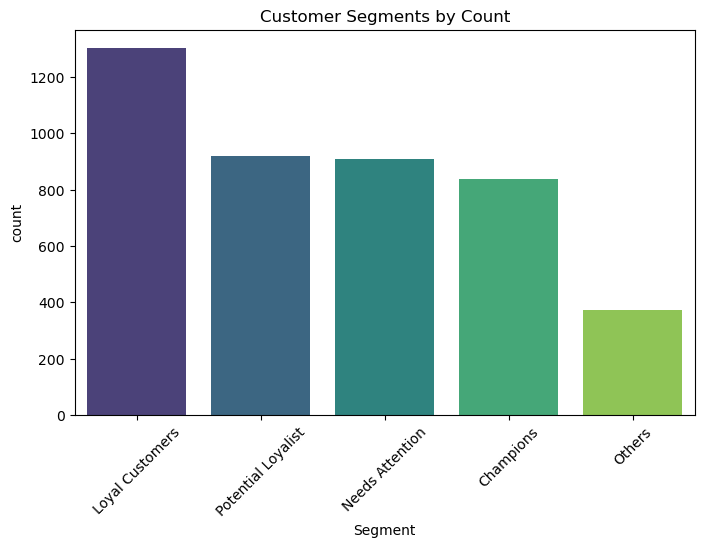

In [30]:
plt.figure(figsize=(8,5))
sns.countplot(data=rfm_df, x='Segment', order=rfm_df['Segment'].value_counts().index, palette="viridis")
plt.title("Customer Segments by Count")
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_84515/1310999351.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_monetary_heatmap = rfm_df.groupby(['F_Score', 'M_Score']).size().unstack(fill_value=0)


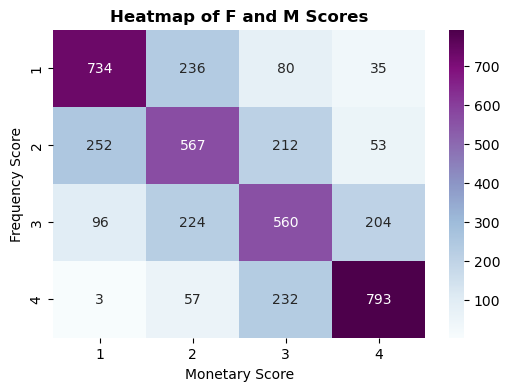

In [ ]:
# Frequency vs Monetary Scores
plt.figure(figsize=(6, 4))
rfm_monetary_heatmap = rfm_df.groupby(['F_Score', 'M_Score']).size().unstack(fill_value=0)
sns.heatmap(rfm_monetary_heatmap, cmap='BuPu', annot=True, fmt='d')
plt.title('Heatmap of F and M Scores', weight='bold')
plt.xlabel('Monetary Score')
plt.ylabel('Frequency Score')
plt.show()

/tmp/ipykernel_84515/2420619339.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_heatmap = rfm_df.groupby(['R_Score', 'F_Score']).size().unstack()


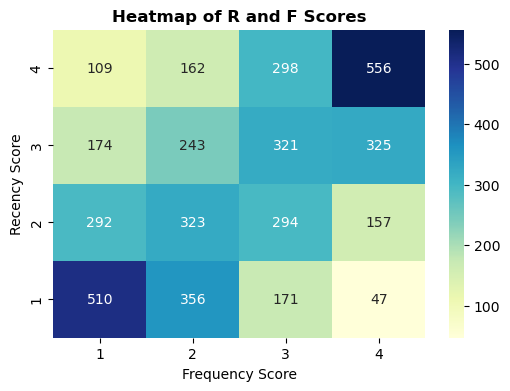

In [34]:
# Recency vs Frequency Scores
plt.figure(figsize=(6, 4))
rfm_heatmap = rfm_df.groupby(['R_Score', 'F_Score']).size().unstack()
sns.heatmap(rfm_heatmap, cmap='YlGnBu', annot=True, fmt='g')
plt.title('Heatmap of R and F Scores', weight='bold')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()

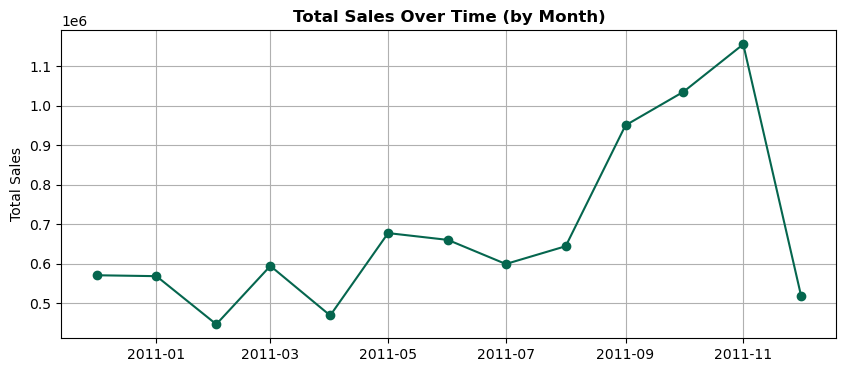

In [53]:


# Total Sales Over Time (by Month)
df['Sales'] = df['Quantity'] * df['UnitPrice']
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp()
monthly_sales = df.groupby('InvoiceMonth')['Sales'].sum().reset_index()

plt.figure(figsize=(10, 4))
plt.plot(monthly_sales['InvoiceMonth'], monthly_sales['Sales'], marker='o', color="#05664E")
plt.title('Total Sales Over Time (by Month)', weight='bold')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

/tmp/ipykernel_84515/2331019888.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_sales.values, y=country_sales.index, palette="viridis")


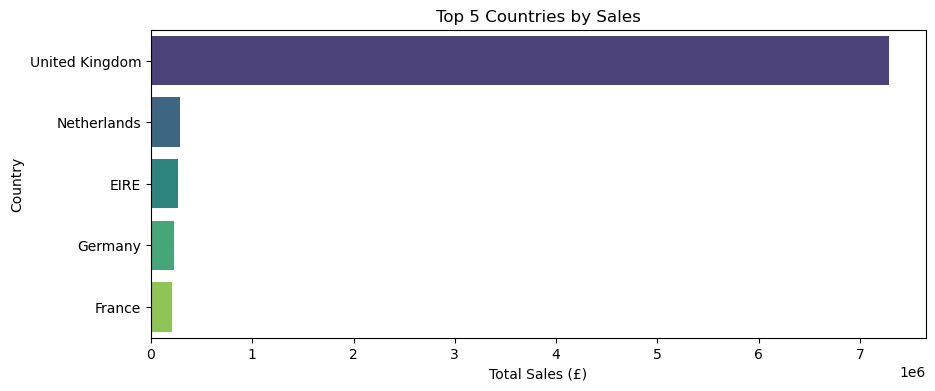

In [55]:
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(10,4))
sns.barplot(x=country_sales.values, y=country_sales.index, palette="viridis")
plt.title("Top 5 Countries by Sales")
plt.xlabel("Total Sales (£)")
plt.show()


/tmp/ipykernel_84515/3648948382.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_sales.values, y=product_sales.index, palette="mako")


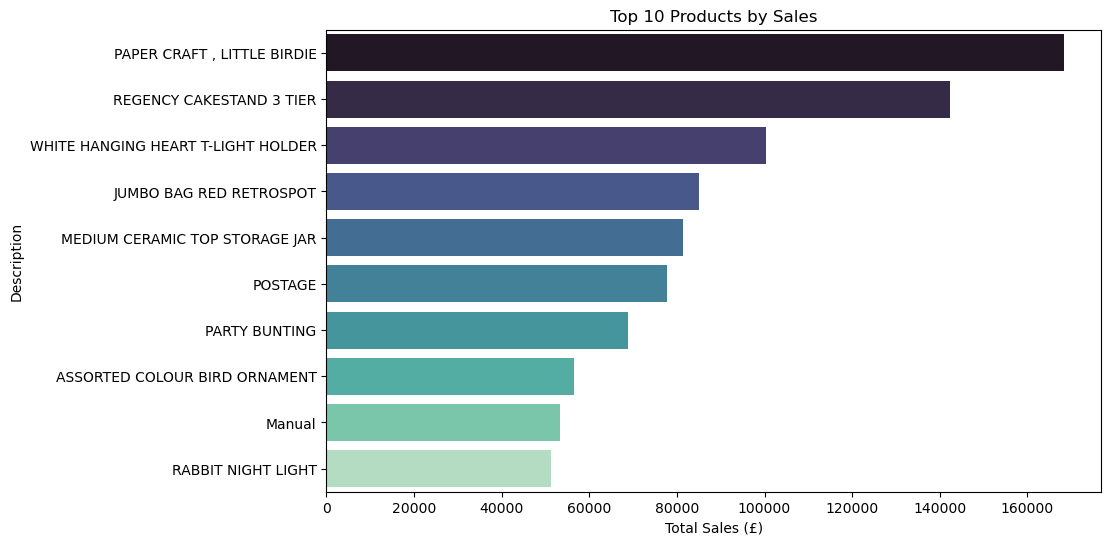

In [42]:
product_sales = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=product_sales.values, y=product_sales.index, palette="mako")
plt.title("Top 10 Products by Sales")
plt.xlabel("Total Sales (£)")
plt.show()


/tmp/ipykernel_84515/4289649814.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='DayOfWeek', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], palette="viridis")


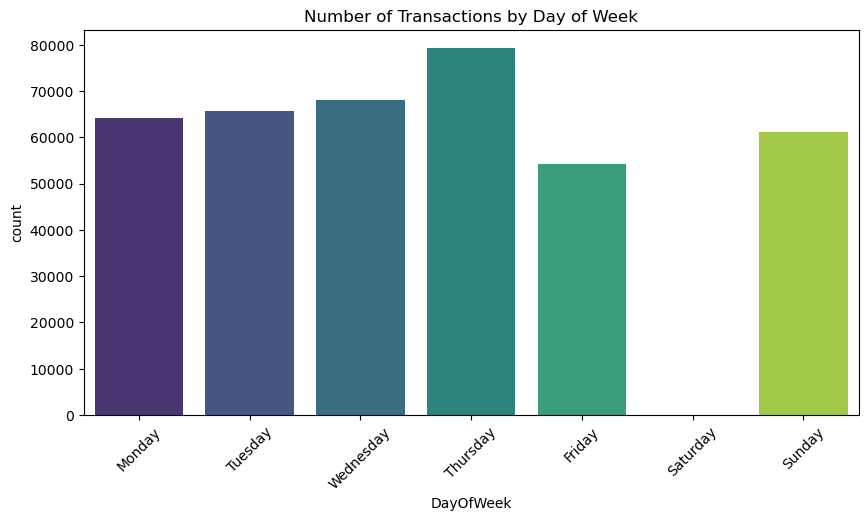

/tmp/ipykernel_84515/4289649814.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Hour', palette="coolwarm")


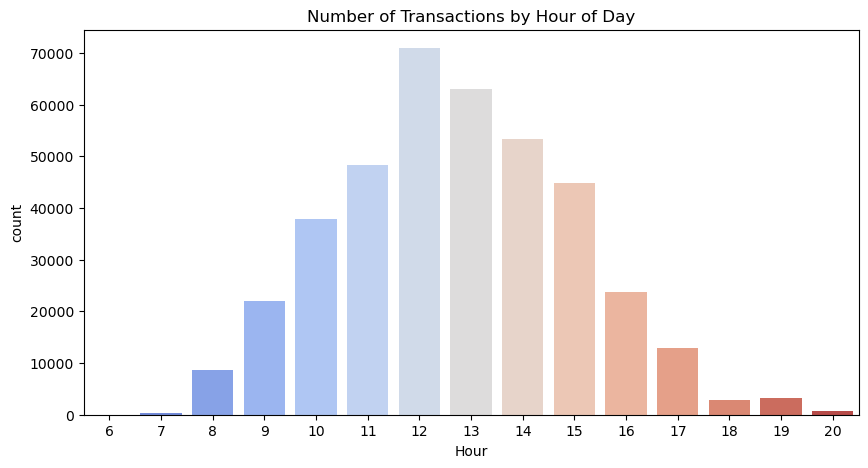

In [44]:
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='DayOfWeek', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], palette="viridis")
plt.title("Number of Transactions by Day of Week")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Hour', palette="coolwarm")
plt.title("Number of Transactions by Hour of Day")
plt.show()
